### Inverted Pendulum on cart


### System model
ref: https://www.researchgate.net/publication/273170289_Optimal_Control_of_Nonlinear_Inverted_Pendulum_System_Using_PID_Controller_and_LQR_Performance_Analysis_Without_and_With_Disturbance_Input

$\frac{\mathrm{d} \boldsymbol{x}}{\mathrm{d} t}=\frac{\mathrm{d}}{\mathrm{d} t}\left[\begin{array}{l}x_{1} \\ x_{2} \\ x_{3} \\ x_{4}\end{array}\right]=\frac{\mathrm{d}}{\mathrm{d} t}\left[\begin{array}{c}\theta \\ \dot{\theta} \\ x \\ \dot{x}\end{array}\right]=\left[\begin{array}{c}f_{1} \\ f_{2} \\ f_{3} \\ f_{4}\end{array}\right] = \left[\begin{array}{c} x_2\\ \frac{u \cos x_{1}-(M+m) g \sin x_{1}+m l\left(\cos x_{1} \sin x_{1}\right) x_{2}^{2}}{m l \cos ^{2} x_{1}-(M+m) l}  \\ x_4 \\ \frac{u+m l(\sin x_1) x_2^{2}-m g \cos x_1 \sin x_1}{M+m-m \cos ^{2} x_1} \end{array}\right]$

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def inverted_pendulum_nonlinear_ode(x, u):
    M  = 2.4
    m = 0.23
    l = 0.36
    g = 9.81

    dx1_dt = x[1]
    dx2_dt = ( u * ca.cos(x[0]) - (M+m) * g * ca.sin(x[0]) + m * l * ca.cos(x[0]) *ca.sin(x[0])*x[1]**2) / (m*l*ca.cos(x[0])**2 - (M+m) *l)
    dx3_dt = x[3]
    dx4_dt = (u + m*l * ca.sin(x[0]) * x[1]**2 - m*g*ca.cos(x[0])*ca.sin(x[0]))/(M+m-m*ca.cos(x[0])**2)
    rhs = [dx1_dt,
           dx2_dt,
           dx3_dt,
           dx4_dt
           ]
    
    return ca.vertcat(*rhs)

In [3]:
x_SX = ca.SX.sym("x_SX", 4)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [inverted_pendulum_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1
# N = 5

In [4]:
ode.sx_in()

[SX([x_SX_0, x_SX_1, x_SX_2, x_SX_3]), SX(u_SX)]

In [5]:
def integrator_rk4(f, x, u, delta_t):
    '''
    This function calculates the integration of stage cost with RK4.
    '''

    k1 = f(x, u)
    k2 = f(x + delta_t / 2 * k1, u)
    k3 = f(x + delta_t / 2 * k2, u)
    k4 = f(x + delta_t * k3, u)


    x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_next

In [6]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

In [7]:
A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

In [8]:
x0 =  ca.SX.sym("x0_SX", 4)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 4)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0)
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

### Test 1: state evolution

(a) constant input u = 0, system evolves by only considering linear term $Ax_k + Bu_k$

In [9]:
N = 100

x_init = np.array([[0],[0],[0],[0]])


x_next = A_fn(x0,u0) @ xk +  B_fn(x0,u0) @ uk
x_next_fn = ca.Function("x_next_fn",[x0,xk,u0,uk],[x_next])

In [10]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

In [11]:
uk = np.array([[0.1]])
xk = x_init
for i in range(N):
    if i == 0:
        x0 = np.array([[0],[0],[0],[0]])
        u0 = uk
    
    x_next = x_next_fn(x0,xk,u0,uk)
    print(x_next)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

[-0.000593104, -0.0121501, 0.000208787, 0.0041848]
[-0.00255245, -0.0280187, 0.000840815, 0.00848667]
[-0.00647744, -0.0524574, 0.00191495, 0.0130583]
[-0.0135685, -0.0929382, 0.00346899, 0.0181349]
[-0.0259939, -0.161833, 0.00557114, 0.0241049]
[-0.0475511, -0.280166, 0.00834065, 0.0316248]
[-0.0848191, -0.483894, 0.0119829, 0.0417973]
[-0.149122, -0.834096, 0.0168454, 0.0563895]
[-0.259748, -1.43159, 0.0234868, 0.0777693]
[-0.448605, -2.4278, 0.0326643, 0.106662]
[-0.76414, -3.98378, 0.0446936, 0.129333]
[-1.26302, -6.0415, 0.0560984, 0.0722855]
[-1.96972, -8.00644, 0.0504528, -0.244104]
[-2.83069, -8.77379, -0.00190152, -0.782338]
[-3.49536, -2.57905, -0.0749929, -0.376304]
[-3.13659, 9.06804, -0.0536362, 0.695034]
[-1.87753, 15.4257, 0.0226044, 0.794968]
[-0.154762, 17.72, 0.10802, 0.695697]
[1.69977, 20.4047, 0.107258, -0.426076]
[3.80762, 23.358, 0.2064, 2.62759]
[5.47158, 6.18735, 0.291563, -2.22599]
[6.60035, 18.6495, -0.0357094, -1.43812]
[9.30076, 37.4848, -0.185093, -1.61411

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3192907827.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3192907827.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3192907827.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3192907827.py:7: MatplotlibDeprecationWarning: Passing non-integers 

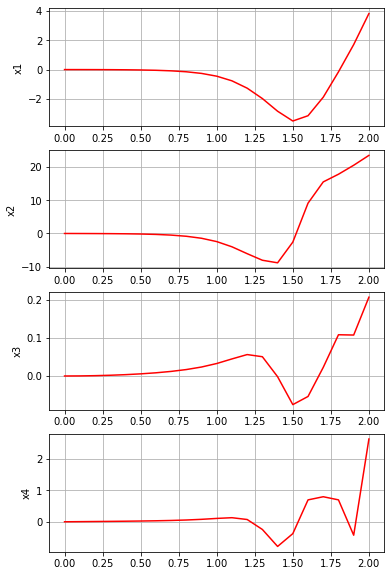

In [12]:
x_plot = np.array(x_list1)
N_plot = 20
tgrid = [delta_t * k for k in range(N_plot + 1)]
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:N_plot+1,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [13]:
x_list2 = []
x_list2.append(x_init.flatten().tolist())

In [14]:
uk = np.array([[0.1]])
xk = x_init

for i in range(N):
    x_next = x_next_fn_lin(xk,xk,uk,uk)
#     print(x_next)
    x_list2.append(x_next.full().flatten().tolist())
    xk = x_next

In [15]:
x_plot = np.array(x_list1)
N_plot = 20
tgrid = [delta_t * k for k in range(N_plot + 1)]

In [16]:
x_list2

[[0, 0, 0, 0],
 [-0.0005931044726626505,
  -0.012150104508938298,
  0.0002087867103728716,
  0.004184801695032171],
 [-0.002552447119481473,
  -0.028018666873550924,
  0.0008408146015742454,
  0.008486668406303565],
 [-0.0064774377159006365,
  -0.052457289124416585,
  0.0019149536747618658,
  0.013058316142561898],
 [-0.013568471509037972,
  -0.09293772264389379,
  0.0034689868446849364,
  0.018134802121685244],
 [-0.02599374905020419,
  -0.16183109060212353,
  0.005571118807614058,
  0.024104584716047404],
 [-0.047550633114001165,
  -0.28016149033308313,
  0.008340578634003228,
  0.031623951762608994],
 [-0.08481777117633979,
  -0.48388110234781656,
  0.011982723112948304,
  0.04179486882771931],
 [-0.14911923655180678,
  -0.8340716557662979,
  0.016844757845026998,
  0.05638423252895748],
 [-0.2597444248282574,
  -1.4316514835761194,
  0.023485760284843584,
  0.07777334715096529],
 [-0.4486561730467257,
  -2.429612773234763,
  0.03267025088636222,
  0.10690968821762434],
 [-0.7650067

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1377604256.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1377604256.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1377604256.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1377604256.py:6: MatplotlibDeprecationWarning: Passing non-integers 

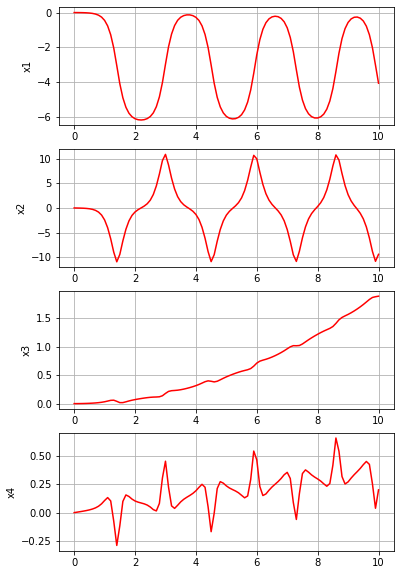

In [17]:
x_plot = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [18]:
x_list3 = []
x_list3.append(x_init.flatten().tolist())

In [19]:
uk = np.array([[0.1]])
xk = x_init

for i in range(N):
    if i == 0:
        x0 = np.array([[0],[0],[0],[0]])
        u0 = uk

    x_next = x_next_fn_lin(x0,xk,u0,uk)
    print(x_next)
    x_list3.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

[-0.000593104, -0.0121501, 0.000208787, 0.0041848]
[-0.00255245, -0.0280187, 0.000840815, 0.00848667]
[-0.00647745, -0.0524575, 0.00191495, 0.0130583]
[-0.0135685, -0.0929389, 0.003469, 0.018135]
[-0.0259941, -0.161838, 0.00557117, 0.0241056]
[-0.0475527, -0.280197, 0.00834089, 0.0316292]
[-0.084829, -0.484071, 0.0119844, 0.0418229]
[-0.149178, -0.835052, 0.0168534, 0.0565295]
[-0.260046, -1.4366, 0.0235305, 0.078509]
[-0.45015, -2.4533, 0.0328926, 0.110437]
[-0.771824, -4.10554, 0.045833, 0.14741]
[-1.29791, -6.54496, 0.0612749, 0.146832]
[-2.10132, -9.58933, 0.0696459, -0.0214966]
[-3.21757, -12.5515, 0.0480077, -0.42089]
[-4.45594, -10.9726, 0.00508534, -0.263458]
[-5.30573, -6.53107, 0.0106231, 0.262418]
[-5.85931, -4.72336, 0.0363577, 0.220992]
[-6.2832, -3.9751, 0.0565532, 0.187845]
[-6.69696, -4.51831, 0.0753462, 0.193237]
[-7.22854, -6.31456, 0.0955917, 0.205763]
[-7.99467, -9.1384, 0.113018, 0.10706]
[-9.07311, -12.4465, 0.106632, -0.28278]
[-10.4259, -13.5226, 0.0595347, -0.5

In [20]:
x_plot = np.array(x_list3)
tgrid = [delta_t * k for k in range(N + 1)]

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1018811998.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1018811998.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1018811998.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1018811998.py:4: MatplotlibDeprecationWarning: Passing non-integers 

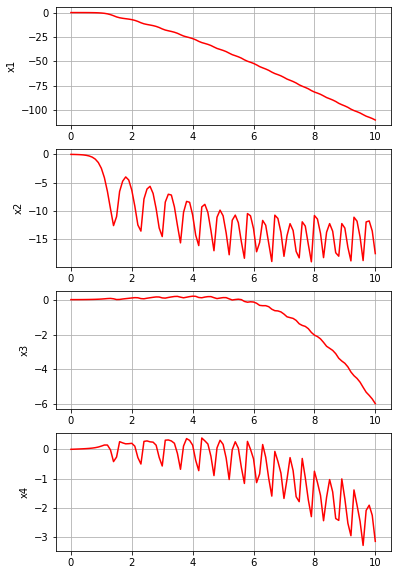

In [21]:
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [22]:
x_list4 = []
x_list4.append(x_init.flatten().tolist())

In [23]:
xk = x_init
for i in range(N):    
    x_next_real = integrator_rk4(ode,xk,uk,delta_t)
    x_list4.append(x_next_real.full().flatten().tolist())
    xk = x_next_real
    

In [24]:
x_plot

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-5.93104473e-04, -1.21501045e-02,  2.08786710e-04,
         4.18480170e-03],
       [-2.55244773e-03, -2.80186877e-02,  8.40814686e-04,
         8.48667129e-03],
       [-6.47744599e-03, -5.24574742e-02,  1.91495484e-03,
         1.30583425e-02],
       [-1.35685331e-02, -9.29388981e-02,  3.46899569e-03,
         1.81349720e-02],
       [-2.59941236e-02, -1.61837755e-01,  5.57117324e-03,
         2.41055578e-02],
       [-4.75527242e-02, -2.80197471e-01,  8.34088513e-03,
         3.16292426e-02],
       [-8.48289789e-02, -4.84070564e-01,  1.19843758e-02,
         4.18228613e-02],
       [-1.49177940e-01, -8.35051841e-01,  1.68534499e-02,
         5.65295159e-02],
       [-2.60045757e-01, -1.43660294e+00,  2.35305027e-02,
         7.85089747e-02],
       [-4.50150300e-01, -2.45330360e+00,  3.28925624e-02,
         1.10436764e-01],
       [-7.71824335e-01, -4.10554283e+00,  4.58329724e-02,
      

In [25]:
x_plot = np.array(x_list4)
tgrid = [delta_t * k for k in range(N + 1)]
# x1_plot = x_plot[:,0]
# x2_plot = x_plot[:,1]
# x3_plot = x_plot[:,2]
# x4_plot = x_plot[:,3]

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1018811998.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1018811998.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1018811998.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1018811998.py:4: MatplotlibDeprecationWarning: Passing non-integers 

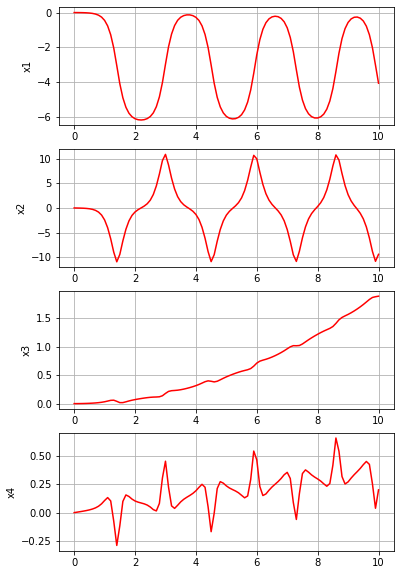

In [26]:
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

### Test 2: Evolution within a short interval

#### $\Delta_{sample} = 0.1 s$, $\Delta_{interval} = 1s$

In [27]:
100 % 10

0

In [28]:
N

100

In [29]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.

for i in range(N):
    if i == 0:
        x0 = x_init
        u0 = uk

        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


#### $\Delta_{sample} = 0.1 s$, $\Delta_{interval} = 1s$

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integ

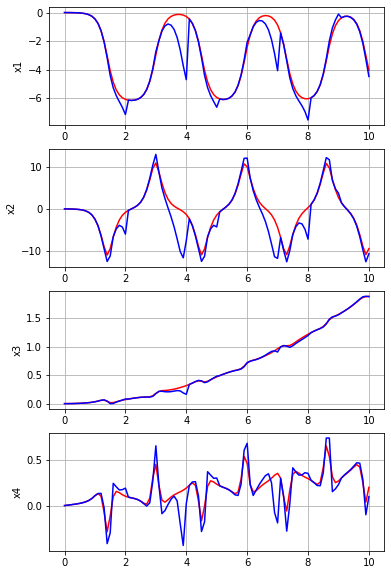

In [30]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

#### without updating $x_0$ within $\Delta_{interval}$

In [31]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.

for i in range(N):
#     if i == 0:
#         x0 = x_init
#         u0 = uk
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    

    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
#     x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integ

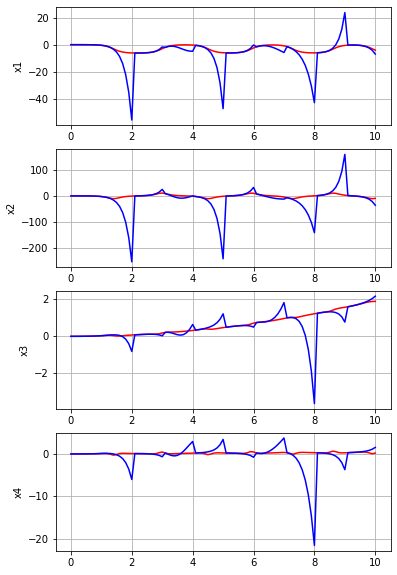

In [32]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

#### $\Delta_{sample} = 0.01 s$, $\Delta_{interval} = 1s$

In [33]:
x_SX = ca.SX.sym("x_SX", 4)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [inverted_pendulum_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.01

sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 4)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 4)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0) 
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

In [34]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 100 # give accurate state every 1 second.
N = 1000
for i in range(N):
    if i == 0:
        x0 = x_init
        u0 = uk

        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

0
100
200
300
400
500
600
700
800
900


/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integ

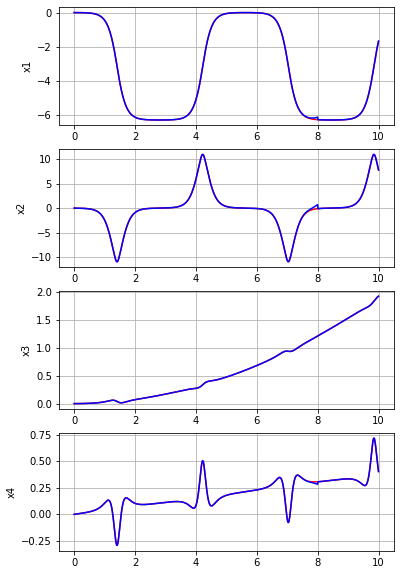

In [35]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### Test 3: Time-varying input

#### $\Delta_{sample} = 0.1 s$, $\Delta_{interval} = 1s$

In [36]:
N = 100

In [37]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.
N = 100
for i in range(N):
    
    uk = np.sin(i * delta_t)
    if i == 0:
        x0 = x_init
        u0 = uk

    
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integ

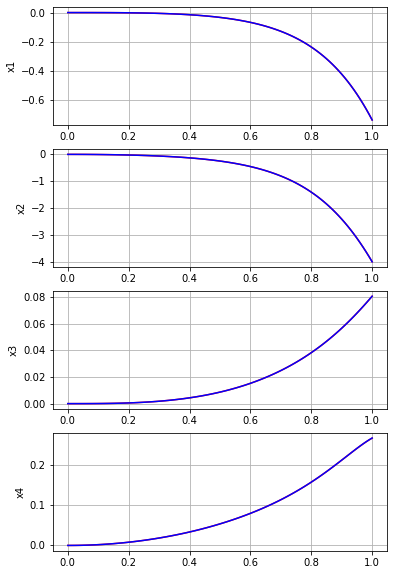

In [38]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

#### without updating $x_0$ within $\Delta_{interval}$

$\Delta_{interval} = 1s$

In [39]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.

for i in range(N):
#     if i == 0:
#         x0 = x_init
#         u0 = uk
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    

    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
#     x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integ

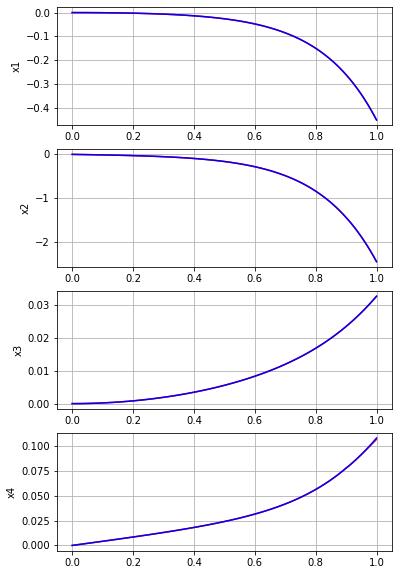

In [40]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

$\Delta_{interval} = 0.5s$

In [41]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 5 # give accurate state every 0.5 second.

for i in range(N):
#     if i == 0:
#         x0 = x_init
#         u0 = uk
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    

    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
#     x0 = xk_appr
    xk_appr = x_next_appr

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integ

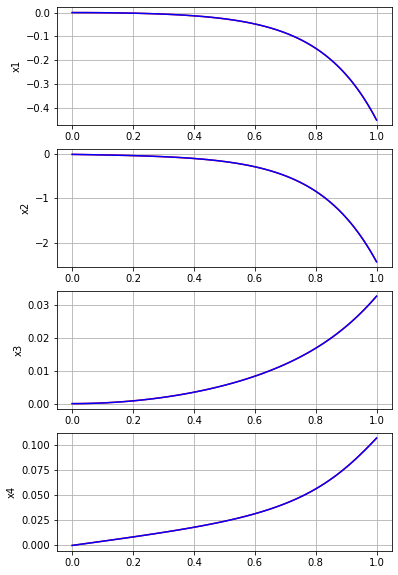

In [42]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### Test 4: MPC

#### $\Delta_{sample} = 0.1 s$

In [43]:
x_SX = ca.SX.sym("x_SX", 4)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [inverted_pendulum_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1

sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 4)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 4)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0) 
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

delta_fn = ca.Function("delta_fn", [x0,u0], [sys_int_fn(x0,u0) - A_fn(x0,u0) @  x0 - B_fn(x0,u0) @ u0] )

In [44]:
sys_int_fn(x0,u0)

SX(@1=0.0166667, @2=2, @3=0.05, @4=25.8003, @5=0.0828, @6=0.9468, @7=((((u0_SX*cos(x0_SX_0))-(@4*sin(x0_SX_0)))+(((@5*cos(x0_SX_0))*sin(x0_SX_0))*sq(x0_SX_1)))/((@5*sq(cos(x0_SX_0)))-@6)), @8=(x0_SX_1+(@3*@7)), @9=(x0_SX_0+(@3*x0_SX_1)), @10=((((u0_SX*cos(@9))-(@4*sin(@9)))+(((@5*cos(@9))*sin(@9))*sq(@8)))/((@5*sq(cos(@9)))-@6)), @11=(x0_SX_1+(@3*@10)), @12=0.1, @13=(x0_SX_0+(@3*@8)), @14=((((u0_SX*cos(@13))-(@4*sin(@13)))+(((@5*cos(@13))*sin(@13))*sq(@11)))/((@5*sq(cos(@13)))-@6)), @15=(x0_SX_1+(@12*@14)), @16=(x0_SX_0+(@12*@11)), @17=2.2563, @18=2.63, @19=0.23, @20=(((u0_SX+((@5*sin(x0_SX_0))*sq(x0_SX_1)))-((@17*cos(x0_SX_0))*sin(x0_SX_0)))/(@18-(@19*sq(cos(x0_SX_0))))), @21=(((u0_SX+((@5*sin(@9))*sq(@8)))-((@17*cos(@9))*sin(@9)))/(@18-(@19*sq(cos(@9))))), @22=(((u0_SX+((@5*sin(@13))*sq(@11)))-((@17*cos(@13))*sin(@13)))/(@18-(@19*sq(cos(@13))))), [(x0_SX_0+(@1*(((x0_SX_1+(@2*@8))+(@2*@11))+@15))), (x0_SX_1+(@1*(((@7+(@2*@10))+(@2*@14))+((((u0_SX*cos(@16))-(@4*sin(@16)))+(((@5*cos(@16

In [45]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]

N_pred = 20

xi_var = ca.SX.sym('x', 4, N_pred+1)
x0_para = ca.SX.sym('x0', 4, 1)
x_lin_para = ca.SX.sym('xlin', 4, 1)
# yr_para = ca.SX.sym('yr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)

# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 1000 * np.eye(4)
R = 1 * np.eye(1)
Qf = 10 * np.eye(4)

g = []

delta = delta_fn(x_lin_para,u_lin_para)
for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:,i-1] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,i-1] + delta)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para, x_lin_para, u_lin_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_appr = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



#### Simulation

In [46]:
[xk, x_lin_para, u_lin_para]

[SX([xk_SX_0, xk_SX_1, xk_SX_2, xk_SX_3]),
 SX([xlin_0, xlin_1, xlin_2, xlin_3]),
 SX(ulin)]

In [47]:
lbg =  [0] * 4 * (N_pred + 1)
ubg =  [0] * 4 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg


x0 = np.array([[np.pi],[0],[0],[0]])
u0 = np.array([[0]])

x_appr_list = []

xk = x0
uk = u0


x_appr_list.append( xk.flatten().tolist())

In [48]:
u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [49]:

# Simulation for 20 seconds
N_sim = 200
for i in range(N_sim):
    if i == 0:
        x_lin = x0
        u_lin = u0
    
    p = np.vstack([xk, x_lin, u_lin])
    nl['p'] = p
    
    sol = solver_appr(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



#### Real system

In [50]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]



N_pred = 20

xi_var = ca.SX.sym('x', 4, N_pred+1)
x0_para = ca.SX.sym('x0', 4, 1)
x_lin_para = ca.SX.sym('xlin', 4, 1)
# yr_para = ca.SX.sym('yr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)

# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 1000 * np.eye(4)
R = 1 * np.eye(1)
Qf = 10 * np.eye(4)

g = []


for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



In [51]:
lbg =  [0] * 4 * (N_pred + 1)
ubg =  [0] * 4 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg


x0 = np.array([[np.pi],[0],[0],[0]])
u0 = np.array([[0]])

x_real_list = []

xk = x0
uk = u0


x_real_list.append(xk.flatten().tolist())

In [52]:
u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [53]:

# Simulation for 20 seconds
N_sim = 200
for i in range(N_sim):
    p = np.vstack([xk])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next


CasADi - 2021-08-19 14:28:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 9, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 9, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 5, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 5, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 5, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 9, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:49 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 4, col 0).")

Sorry, things failed ?!?!


2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../cas

CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).")

CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-19 14:28:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).")

In [54]:
x_real_list

[[3.141592653589793, 0.0, 0.0, 0.0],
 [44.730380059853985,
  559.4943928625253,
  17.997338691786112,
  936.9279970927826],
 [54.43191574720512,
  -449.57465456547664,
  112.40634883145432,
  670.2640430164099],
 [-57.69476289382073,
  -1559.0001376843393,
  -13.346408276045196,
  -2908.3304038100296],
 [-2615.8537391006153,
  -5201626.139106144,
  -1319.3408556279699,
  -16841794.606140934],
 [7.16338142860874e+32,
  -8.038690151743654e+65,
  -5.7738230600260345e+32,
  -9.289580321835041e+65],
 [-inf, nan, -inf, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan

In [55]:
x_plot_appr

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-5.78847712e-06, -1.15798344e-03,  2.08337867e-06,
         4.16684802e-04],
       [-2.31711966e-05, -2.31942565e-03,  8.33405896e-06,
         8.33478496e-04],
       [-5.22000786e-05, -3.48779572e-03,  1.87536755e-05,
         1.25049030e-03],
       [-9.29618293e-05, -4.66658345e-03,  3.33449580e-05,
         1.66783008e-03],
       [-1.45578199e-04, -5.85930974e-03,  5.21117395e-05,
         2.08560869e-03],
       [-2.10206348e-04, -7.06953710e-03,  7.50589679e-05,
         2.50393827e-03],
       [-2.87039312e-04, -8.30088038e-03,  1.02192720e-04,
         2.92293265e-03],
       [-3.76306582e-04, -9.55701747e-03,  1.33520222e-04,
         3.34270761e-03],
       [-4.78274791e-04, -1.08417003e-02,  1.69049868e-04,
         3.76338126e-03],
       [-5.93248506e-04, -1.21587661e-02,  2.08791245e-04,
         4.18507443e-03],
       [-7.21571129e-04, -1.35121479e-02,  2.52755165e-04,
      

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/2913136980.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/2913136980.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/2913136980.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/2913136980.py:10: MatplotlibDeprecationWarning: Passing non-integ

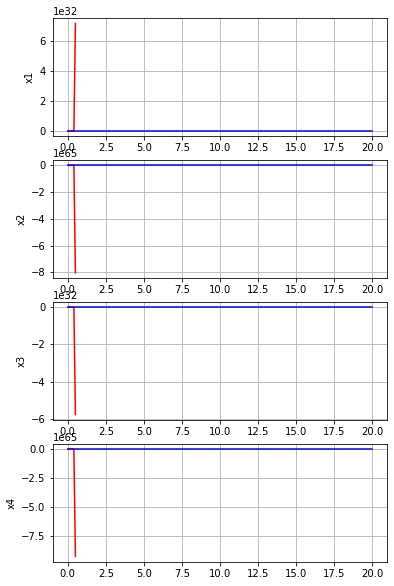

In [56]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

In [57]:
x_plot_appr

array([[ 3.14159265e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 3.14483488e+00,  6.31896510e-02,  1.19438400e-03,
         2.38355709e-02],
       [ 3.15000530e+00,  3.77343648e-02,  3.41981355e-03,
         2.05948127e-02],
       [ 3.15261353e+00,  1.31913388e-02,  5.52595640e-03,
         2.14890513e-02],
       [ 3.15304233e+00, -4.80175034e-03,  7.90957566e-03,
         2.61774611e-02],
       [ 3.15194652e+00, -1.65669006e-02,  1.08540966e-02,
         3.27301937e-02],
       [ 3.14991499e+00, -2.30673930e-02,  1.44691177e-02,
         3.96015941e-02],
       [ 3.14743064e+00, -2.54079520e-02,  1.87333874e-02,
         4.57219424e-02],
       [ 3.14486337e+00, -2.46893260e-02,  2.35395805e-02,
         5.04412174e-02],
       [ 3.14247492e+00, -2.19210921e-02,  2.87323807e-02,
         5.34512655e-02],
       [ 3.14043093e+00, -1.79689613e-02,  3.41385934e-02,
         5.47041459e-02],
       [ 3.13881702e+00, -1.35294511e-02,  3.95893057e-02,
      

### New linearization approach: linearize at the current state

In [58]:
x_SX = ca.SX.sym("x_SX", 4)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [inverted_pendulum_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1
# N = 5

In [59]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])
A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 4)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 4)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0)
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

In [60]:
N = 100

x_init = np.array([[0],[0],[0],[0]])


x_next = A_fn(x0,u0) @ xk +  B_fn(x0,u0) @ uk
x_next_fn = ca.Function("x_next_fn",[x0,xk,u0,uk],[x_next])

x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk = x_init

for i in range(N):
    if i == 0:
        u0 = uk

    x_next = x_next_fn_lin(xk,xk,u0,uk)
#     x_next = x_next_fn_lin(x0,xk,u0,uk)
#     print(x_next)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1530827171.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1530827171.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1530827171.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1530827171.py:7: MatplotlibDeprecationWarning: Passing non-integers 

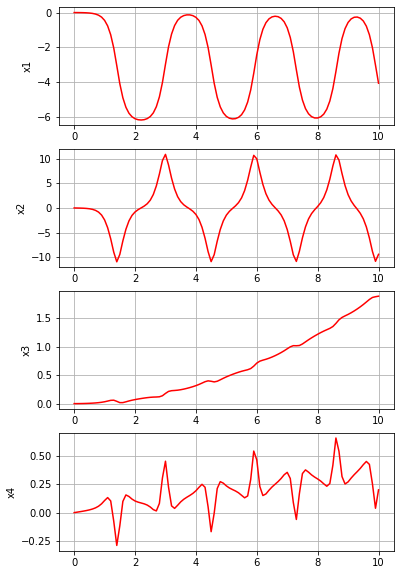

In [61]:
    
x_plot = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

#### $\Delta_{sample} = 0.1 s$, $\Delta_{interval} = 1s$

In [62]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.
N = 100
for i in range(N):
    
    uk = np.sin(i * delta_t)
    if i == 0:
        x0 = x_init
        u0 = uk

    
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3488428309.py:10: MatplotlibDeprecationWarning: Passing non-integ

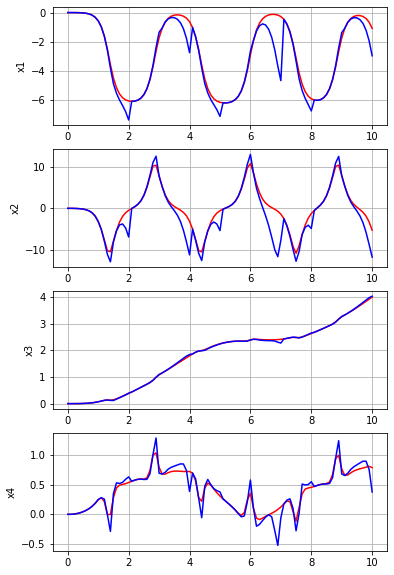

In [63]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### Test: MPC

#### $\Delta_{sample} = 0.1 s$

In [64]:
terminal_state = ca.DM([[0],[0],[0],[0]])

In [65]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]

N_pred = 5

xi_var = ca.SX.sym('x', 4, N_pred+1)
# xi_var = ca.SX.sym('x', 4, N_pred)
x0_para = ca.SX.sym('x0', 4, 1)
x_lin_para = ca.SX.sym('xlin', 4, 1)
# yr_para = ca.SX.sym('yr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)

# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 100 * np.eye(4)
R = 1 * np.eye(1)
Qf = 10 * np.eye(4)

g = []

delta = delta_fn(x_lin_para,u_lin_para)
for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:,i-1] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,i-1] + delta)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        
# g += [terminal_state - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        

# g += [xi_var[:, -1] - terminal_state]
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para, x_lin_para, u_lin_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_appr = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



Approximated system

In [66]:
N_sim = 200

In [67]:
lbg =  [0] * 4 * (N_pred + 1)
ubg =  [0] * 4 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2
x1_start = np.pi

x0 = np.array([[x1_start],[0],[0],[0]])
u0 = np.array([[0]])

x_appr_list = []

xk = x0
uk = u0

# nl['x0'] = [0, 0, 0, 0] * (N_pred+1) + [0] * N_pred

x_appr_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]


# Simulation for 20 seconds

for i in range(N_sim):
    x_lin = xk
    u_lin = uk
    
    p = np.vstack([xk, x_lin, u_lin])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    xk = x_next

input [[-4.47457519]
 [-1.43590462]
 [-0.88878508]
 [-0.8187194 ]
 [-0.40018719]]
input [[-1.87032373]
 [-1.66052597]
 [-1.87278895]
 [-1.65943695]
 [-0.53744066]]
input [[-1.77531149]
 [-2.56318373]
 [-2.79280181]
 [-2.23161024]
 [-0.60034058]]
input [[-2.39878528]
 [-3.44062309]
 [-3.42081201]
 [-2.50217342]
 [-0.59686237]]
input [[-3.04507019]
 [-4.02285784]
 [-3.67795899]
 [-2.47324621]
 [-0.53689342]]
input [[-3.46520893]
 [-4.23185623]
 [-3.57114244]
 [-2.18519111]
 [-0.43495207]]
input [[-3.59030651]
 [-4.08548152]
 [-3.1626203 ]
 [-1.70655873]
 [-0.30765254]]
input [[-3.4279954 ]
 [-3.65031192]
 [-2.5417443 ]
 [-1.11498646]
 [-0.17030991]]
input [[-3.02464208]
 [-3.01325636]
 [-1.80127509]
 [-0.48124905]
 [-0.03514233]]
input [[-2.44733539]
 [-2.26272259]
 [-1.02244392]
 [ 0.13871719]
 [ 0.08901973]]
input [[-1.77029137]
 [-1.47716186]
 [-0.26898861]
 [ 0.70482106]
 [ 0.19623495]]
input [[-1.06351418]
 [-0.71972105]
 [ 0.41283531]
 [ 1.19035659]
 [ 0.28281937]]
input [[-0.38513

input [[ 0.06937355]
 [-0.55335357]
 [-0.21958428]
 [ 0.09613438]
 [-0.02544595]]
input [[ 0.06779882]
 [-0.55630321]
 [-0.22294405]
 [ 0.09293492]
 [-0.02610381]]
input [[ 0.06626255]
 [-0.55918418]
 [-0.2262272 ]
 [ 0.0898076 ]
 [-0.02674702]]
input [[ 0.06476224]
 [-0.56199962]
 [-0.22943675]
 [ 0.08674995]
 [-0.02737603]]
input [[ 0.06329573]
 [-0.5647523 ]
 [-0.23257532]
 [ 0.08375985]
 [-0.02799123]]
input [[ 0.06186117]
 [-0.56744454]
 [-0.23564512]
 [ 0.0808355 ]
 [-0.02859294]]
input [[ 0.06045709]
 [-0.57007826]
 [-0.23864795]
 [ 0.07797539]
 [-0.02918143]]
input [[ 0.05908237]
 [-0.57265502]
 [-0.24158533]
 [ 0.0751782 ]
 [-0.02975695]]
input [[ 0.05773615]
 [-0.57517609]
 [-0.24445852]
 [ 0.07244282]
 [-0.03031971]]
input [[ 0.05641788]
 [-0.57764246]
 [-0.24726856]
 [ 0.06976825]
 [-0.03086988]]
input [[ 0.05512716]
 [-0.58005497]
 [-0.25001638]
 [ 0.06715355]
 [-0.03140767]]
input [[ 0.05386375]
 [-0.58241432]
 [-0.25270286]
 [ 0.06459781]
 [-0.03193325]]
input [[ 0.05262

Real system

In [68]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]



N_pred = 10

# xi_var = ca.SX.sym('x', 4, N_pred+1)
xi_var = ca.SX.sym('x', 4, N_pred)
x0_para = ca.SX.sym('x0', 4, 1)
x_lin_para = ca.SX.sym('xlin', 4, 1)
# yr_para = ca.SX.sym('yr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)

# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 10 * np.eye(4)
R = 1 * np.eye(1)
Qf = 10 * np.eye(4)

g = []


for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



lbg =  [0] * 4 * (N_pred + 1)
ubg =  [0] * 4 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

In [69]:
x0 = np.array([[x1_start],[0],[0],[0]])
u0 = np.array([[0]])

x_real_list = []

xk = x0
uk = u0


x_real_list.append(xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [70]:
# Simulation for 20 seconds
for i in range(N_sim):
    p = np.vstack([xk])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/2913136980.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/2913136980.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/2913136980.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(4) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/2913136980.py:10: MatplotlibDeprecationWarning: Passing non-integ

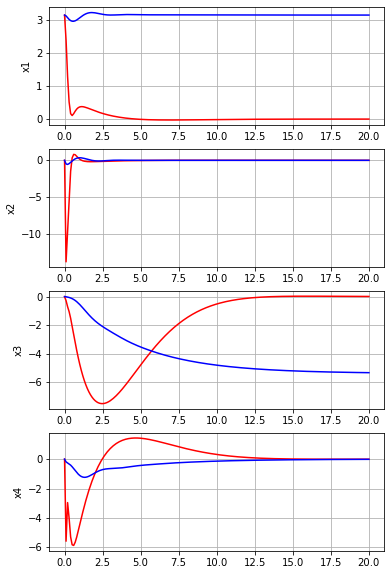

In [71]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### CSTR example

Reference: https://reader.elsevier.com/reader/sd/pii/S1474667017313228?token=224BC5B42F541F7B66DCFCA4C355C5DAF8A9484522CE62C7723030A67751FA3B18D80FE8CF0D7ED3551E17EA1BA2D908&originRegion=eu-west-1&originCreation=20210815142702

$$
\begin{array}{ll}
q_{f} & 100 \\
C_{f} & 1 \\
T_{f} & 350 \\
T_{c} & 350 \\
E / R & 10000 \\
V & 100 \\
K_{0} & 7.2 \cdot 10^{10} \\
K_{1} & 1.44 \cdot 10^{13} \\
K_{2} & 0.01 \\
K_{3} & 700
\end{array}
$$

Mass balance:
$$
\frac{d T}{d t}= \frac{q_{f}}{V}\left(T_{f}-T\right)+K_{1} C e^{-\frac{E}{RT}} +K_{2} q_{c}\left(1-e^{-\frac{K_{3}}{q_c}}\right)\left(T_{c}-T\right)
$$
Energy balance:
$$
\frac{d C}{d t}=\frac{q_{f}}{V}\left(C_{f}-C\right)-K_{0} C e^{-\frac{E}{R T}}
$$

In [72]:
def CSTR_nonlinear_ode(x, u):
    qf = 100
    Cf = 1
    Tf = 350
    Tc = 350
    E_R = 10000
    V = 100
    K0 = 7.2e10
    K1 = 1.44e13
    K2 = 0.01
    K3 = 700
    
    
    dx1_dt = qf/V * (Tf - x[0]) + K1 * x[1] * ca.exp(-E_R/x[0]) + K2 * u[0] * (1 - ca.exp(-K3/u[0])) * (Tc - x[0])
    dx2_dt = qf/V * (Cf - x[1]) - K0 * x[1] * ca.exp(-E_R/x[0])
    rhs = [dx1_dt,
           dx2_dt
           ]
    
    return ca.vertcat(*rhs)

In [73]:
x_SX = ca.SX.sym("x_SX", 2)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [CSTR_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1
# N = 5

In [74]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])
A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 2)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 2)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0)
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

In [75]:
N = 100

x_init = np.array([[432.94],[0.1298]])


x_next = A_fn(x0,u0) @ xk +  B_fn(x0,u0) @ uk
x_next_fn = ca.Function("x_next_fn",[x0,xk,u0,uk],[x_next])

In [76]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk = x_init

for i in range(N):
    if i == 0:
        u0 = uk

    x_next = x_next_fn_lin(xk,xk,u0,uk)
#     x_next = x_next_fn_lin(x0,xk,u0,uk)
#     print(x_next)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

#### Openloop simulation

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/844668810.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/844668810.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


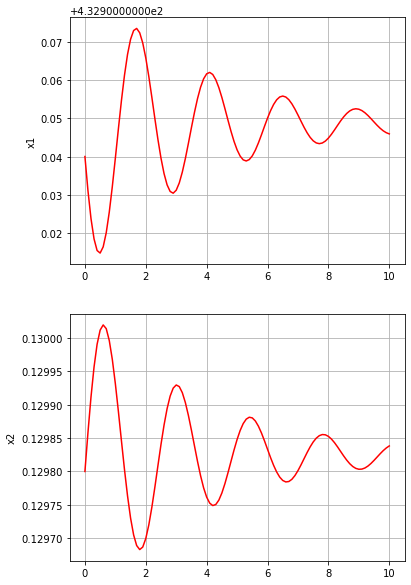

In [77]:
x_plot = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [78]:
x_list1

[[432.94, 0.1298],
 [432.9310417291843, 0.12985827088940946],
 [432.92370541824255, 0.12991141968390385],
 [432.9183950035061, 0.12995618132916417],
 [432.9153606705444, 0.12999000720774584],
 [432.9146902165155, 0.1300111964037518],
 [432.91631116806894, 0.1300189664520756],
 [432.9200030712434, 0.13001346164153746],
 [432.9254188128777, 0.1299957006417375],
 [432.9321133242112, 0.12996746887553343],
 [432.93957758400273, 0.1299311644754704],
 [432.94727551682263, 0.12988960960005155],
 [432.9546812105759, 0.12984584107620445],
 [432.96131388735694, 0.12980289553227506],
 [432.9667682689094, 0.12976360422200509],
 [432.9707383749859, 0.12973041156531281],
 [432.9730333475086, 0.12970522914078902],
 [432.9735845517313, 0.12968933368956784],
 [432.97244390019085, 0.12968331396583072],
 [432.96977400619227, 0.1296870673799861],
 [432.9658313395149, 0.12969984369959395],
 [432.9609439836375, 0.12972032990964102],
 [432.9554858581061, 0.1297467678994514],
 [432.9498493698571, 0.12977709504

In [79]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.
N = 100
for i in range(N):
    
#     uk = np.sin(i * delta_t)
    if i == 0:
        x0 = x_init
        u0 = uk

    
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/750961969.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/750961969.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


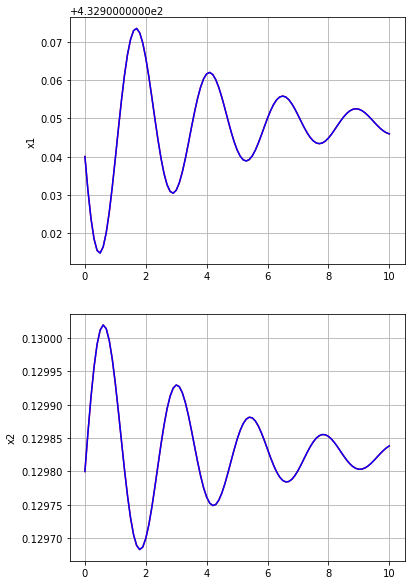

In [80]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

#### step response

In [81]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk = x_init

step_input_list = [110,105,98.9,88.3,68.8]
N_len = len(step_input_list)

N = 50
input_counter = 0
for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1
    uk = step_input_list[input_counter]
    u0 = uk
    x_next = x_next_fn_lin(xk,xk,u0,uk)
#     x_next = x_next_fn_lin(x0,xk,u0,uk)
#     print(x_next)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1589118732.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1589118732.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


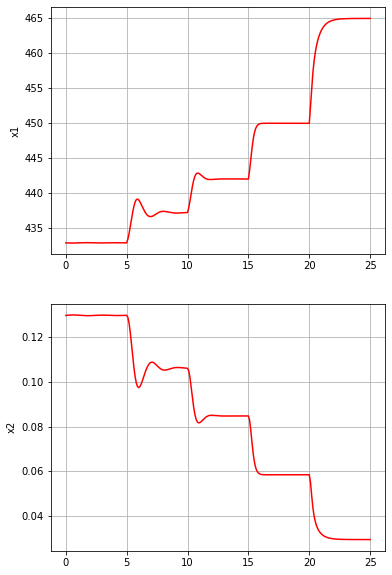

In [82]:
x_plot = np.array(x_list1)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [83]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.
N = 50

step_input_list = [110,105,98.9,88.3,68.8]
N_len = len(step_input_list)
input_counter = 0
for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1
    uk = step_input_list[input_counter]
    u0 = uk

    
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
#     if i % N_delta == 0:
#         print(i)
#         xk_appr = xk_real
#         x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/513079977.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/513079977.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


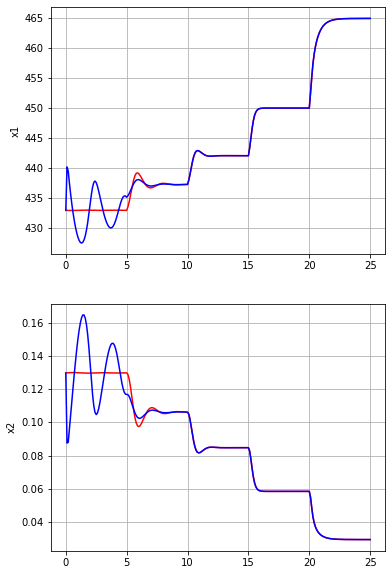

In [84]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N * N_len+ 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### Test: MPC

In [85]:
x_SX = ca.SX.sym("x_SX", 2)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [CSTR_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1

sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 2)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 2)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0) 
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

delta_fn = ca.Function("delta_fn", [x0,u0], [sys_int_fn(x0,u0) - A_fn(x0,u0) @  x0 - B_fn(x0,u0) @ u0] )

In [86]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]

N_pred = 10

xi_var = ca.SX.sym('x', 2, N_pred+1)
# xi_var = ca.SX.sym('x', 4, N_pred)
x0_para = ca.SX.sym('x0', 2, 1)
x_lin_para = ca.SX.sym('xlin', 2, 1)
xr_para = ca.SX.sym('xr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)
ur_para = ca.SX.sym('ur', 1, 1)
# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []

delta = delta_fn(x_lin_para,u_lin_para)
for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  (xi_var[:,i] - xr_para).T @ Q @  (xi_var[:,i] - xr_para) + (ui_var[:,i] - ur_para).T @ R @ (ui_var[:,i] - ur_para)
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:,i-1] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,i-1] + delta)]

obj += (xi_var[:, -1]- xr_para).T @ Qf @ (xi_var[:, -1]- xr_para)
g += [xi_var[:, -1] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        
# g += [terminal_state - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        

# g += [xi_var[:, -1] - terminal_state]
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para, x_lin_para, u_lin_para, xr_para,ur_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_appr = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



In [87]:
N_sim = 200

In [88]:
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2
x1_start = 432.94
x2_start = 0.1298

x1r = 437.25
x2r = 0.1062

x0 = np.array([[x1_start],[x2_start]])
u0 = np.array([[110]])

xr = np.array([[x1r],[x2r]])
ur = np.array([[105]])
x_appr_list = []

xk = x0
uk = u0


x_appr_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]


# Simulation for 20 seconds

for i in range(N_sim):
    x_lin = xk
    u_lin = uk
    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    xk = x_next

input [[ 98.91112958]
 [104.29705523]
 [107.43209384]
 [108.82636615]
 [109.0308685 ]
 [108.53327581]
 [107.71097186]
 [106.82352955]
 [106.02863895]
 [105.40883325]]
input [[104.26369532]
 [107.46193253]
 [108.81123091]
 [108.94774007]
 [108.41432884]
 [107.61088167]
 [106.7926999 ]
 [106.09504668]
 [105.56782892]
 [105.21025212]]
input [[106.95847489]
 [108.2670777 ]
 [108.38324598]
 [107.85441685]
 [107.08568784]
 [106.33424908]
 [105.73300987]
 [105.32502628]
 [105.09709976]
 [105.00663264]]
input [[107.90480868]
 [108.04007799]
 [107.53575195]
 [106.79792181]
 [106.08246716]
 [105.51952786]
 [105.14960629]
 [104.95846439]
 [104.90433968]
 [104.93561597]]
input [[107.8545165 ]
 [107.3885662 ]
 [106.68409689]
 [105.99648027]
 [105.45388825]
 [105.09493734]
 [104.90505448]
 [104.84480904]
 [104.86827985]
 [104.93244208]]
input [[107.32378638]
 [106.64824942]
 [105.98212089]
 [105.45319083]
 [105.09948016]
 [104.90628461]
 [104.83512484]
 [104.84272865]
 [104.8910522 ]
 [104.95065115]

input [[105.0058906 ]
 [105.00607276]
 [105.00623111]
 [105.00633707]
 [105.00633642]
 [105.00614649]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.0058906 ]
 [105.00607277]
 [105.00623112]
 [105.00633707]
 [105.00633642]
 [105.00614649]
 [105.00566411]
 [105.00478964]
 [105.00347267]
 [105.00178242]]
input [[105.0058906 ]
 [105.00607277]
 [105.00623112]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347267]
 [105.00178242]]
input [[105.0058906 ]
 [105.00607277]
 [105.00623112]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633643]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633643]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]

input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]

input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]

Real system

In [89]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]



N_pred = 10

# xi_var = ca.SX.sym('x', 4, N_pred+1)
xi_var = ca.SX.sym('x', 2, N_pred+1)
x0_para = ca.SX.sym('x0', 2, 1)
xr_para = ca.SX.sym('xr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
ur_para = ca.SX.sym('ur', 1, 1)



# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []


for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  (xi_var[:,i] - xr_para).T @ Q @  (xi_var[:,i] - xr_para) + (ui_var[:,i] - ur_para).T @ R @ (ui_var[:,i] - ur_para)
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += (xi_var[:, -1]- xr_para).T @ Qf @ (xi_var[:, -1]- xr_para)
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para,xr_para,ur_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)

In [90]:
xi_var.shape

(2, 11)

In [91]:
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2
x1_start = 432.94
x2_start = 0.1298

x1r = 437.25
x2r = 0.1062
u1r = 105
x0 = np.array([[x1_start],[x2_start]])

xr = np.array([[x1r],[x2r]])
ur = np.array([[u1r]])
x_real_list = []

xk = x0
uk = u0
x_real_list = []
x_real_list.append(xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [92]:
p = np.vstack([xk,xr,ur])
nl['p'] = p
x_guess = [x1r,x2r] * (N_pred+1) + [u1r] * N_pred
nl['x0'] = x_guess
sol = solver_real(**nl)

In [93]:
# Simulation for 20 seconds
for i in range(N_sim):
    p = np.vstack([xk,xr,ur])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3011032303.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/3011032303.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


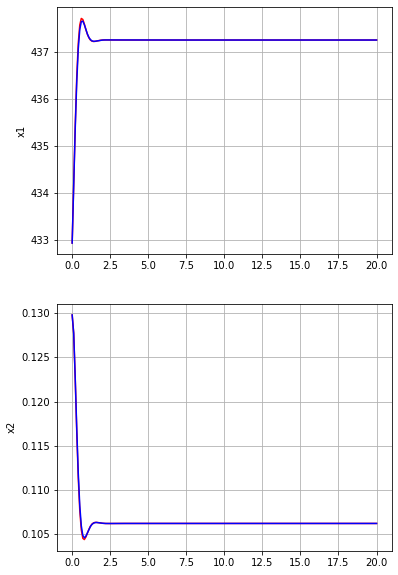

In [94]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

In [95]:
x_appr_list

[[432.94, 0.1298],
 [434.1643867269198, 0.1277554678795236],
 [435.3563413317841, 0.12275835106233204],
 [436.3510560731424, 0.11701232752737155],
 [437.05892624055446, 0.11194981289236305],
 [437.471148893786, 0.10824401839890394],
 [437.64144696954116, 0.1059769326712452],
 [437.6508862777655, 0.10489068431759031],
 [437.57642039852567, 0.10461166238462816],
 [437.474745276943, 0.10479067123588974],
 [437.3797049014437, 0.10516352635322185],
 [437.30671800890894, 0.10556083781548997],
 [437.2590582715396, 0.10589318124530622],
 [437.23339956162, 0.10612821699618023],
 [437.2238037393169, 0.1062684596424932],
 [437.2241758109994, 0.10633352575568494],
 [437.22951273996654, 0.10634791212925354],
 [437.23632401027595, 0.10633385818527875],
 [437.24255725461745, 0.10630815031620548],
 [437.2472857107153, 0.10628155130410022],
 [437.25033283509015, 0.10625967963426651],
 [437.25193647225865, 0.10624445631905124],
 [437.2524979755222, 0.10623555798219614],
 [437.2524232532511, 0.1062315894

Test: linearization around the set point

In [96]:
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2
x1_start = 432.94
x2_start = 0.1298

x1r = 437.25
x2r = 0.1062

x0 = np.array([[x1_start],[x2_start]])
u0 = np.array([[110]])

xr = np.array([[x1r],[x2r]])
ur = np.array([[105]])
x_linear_list = []

xk = x0
uk = u0


x_linear_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]


x_lin = xr
u_lin = ur

x_guess = [x1r,x2r] * (N_pred + 1) + [u1r] * N_pred
nl['x0'] = x_guess
for i in range(N_sim):

    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_linear_list.append(x_next.full().flatten().tolist())
    
    xk = x_next

input [[100.1107006 ]
 [104.55071917]
 [106.87908679]
 [107.68739203]
 [107.57129666]
 [107.01325384]
 [106.3453284 ]
 [105.75946925]
 [105.3393502 ]
 [105.09635387]]
input [[103.99962906]
 [106.75492454]
 [107.80282231]
 [107.78503894]
 [107.23486214]
 [106.52776216]
 [105.88694571]
 [105.41516221]
 [105.13299527]
 [105.01229107]]
input [[106.42253958]
 [107.74857412]
 [107.88143215]
 [107.38689005]
 [106.67471315]
 [105.99677483]
 [105.47651703]
 [105.14805791]
 [104.99196876]
 [104.96175788]]
input [[107.60821819]
 [107.8690874 ]
 [107.44118012]
 [106.74986074]
 [106.06288378]
 [105.5167793 ]
 [105.1553938 ]
 [104.96668037]
 [104.91095018]
 [104.93880181]]
input [[107.83837052]
 [107.44512644]
 [106.7701775 ]
 [106.08534315]
 [105.5310478 ]
 [105.15433059]
 [104.94594623]
 [104.86949994]
 [104.88053896]
 [104.93651435]]
input [[107.45101223]
 [106.7756076 ]
 [106.08920143]
 [105.53159258]
 [105.14907091]
 [104.93183791]
 [104.84362964]
 [104.84145944]
 [104.88632253]
 [104.94706868]

input [[105.00588909]
 [105.00607025]
 [105.00622837]
 [105.00633452]
 [105.00633421]
 [105.00614466]
 [105.00566263]
 [105.00478852]
 [105.00347194]
 [105.00178211]]
input [[105.00588904]
 [105.00607023]
 [105.00622836]
 [105.00633451]
 [105.00633421]
 [105.00614466]
 [105.00566264]
 [105.00478852]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607021]
 [105.00622835]
 [105.00633451]
 [105.00633422]
 [105.00614467]
 [105.00566264]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588901]
 [105.00607021]
 [105.00622836]
 [105.00633452]
 [105.00633422]
 [105.00614467]
 [105.00566265]
 [105.00478853]
 [105.00347195]
 [105.00178211]]
input [[105.005889  ]
 [105.00607021]
 [105.00622836]
 [105.00633452]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347195]
 [105.00178211]]
input [[105.005889  ]
 [105.00607021]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347195]
 [105.00178211]

input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]

input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]

#### Remark:

Simulation result depends on the initial guess.

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/2612852982.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/2612852982.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


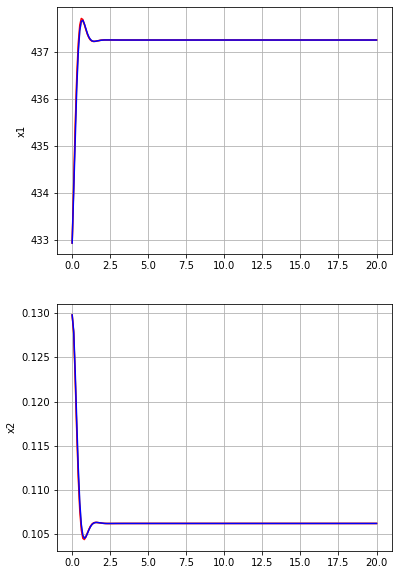

In [97]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_linear = np.array(x_linear_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_linear = x_plot_linear[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_appr, 'orange')
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_linear, 'b')
    plt.ylabel('x' + str(i + 1))

#### Test: Tracking MPC

In [98]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk = x_init

ur_list = [110, 105, 98.9, 88.3, 68.6]
x1r_list = [432.94, 437.25, 442.07, 450.03, 465.00]
x2r_list = [0.1298, 0.1062, 0.0848, 0.0585, 0.0295]

x1_start = 420
x2_start = 0.1
u0 = np.array([[105]])


N = 50
N_len = len(step_input_list)


# for i in range(N * N_len):
#     if i % N == 0 and i != 0:
#         input_counter += 1
#     uk = step_input_list[input_counter]
#     u0 = uk
#     x_next = x_next_fn_lin(xk,xk,u0,uk)
# #     x_next = x_next_fn_lin(x0,xk,u0,uk)
# #     print(x_next)
#     x_list1.append(x_next.full().flatten().tolist())
#     x0 = xk
#     xk = x_next



### Appr
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2




x0 = np.array([[x1_start],[x2_start]])



x_appr_list = []

xk = x0
uk = u0


x_appr_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]



input_counter = 0



for i in range(N * N_len):
    x_lin = xk
    u_lin = uk

    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])   
    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    xk = x_next


### Real
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

x0 = np.array([[x1_start],[x2_start]])

xk = x0
uk = u0
x_real_list = []
x_real_list.append(xk.flatten().tolist())

input_counter = 0

for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])  
    
    
    p = np.vstack([xk,xr,ur])
    nl['p'] = p
    
    x_guess = [x1r_list[input_counter],x2r_list[input_counter]] * (N_pred+1) + [ur_list[input_counter]] * N_pred
    nl['x0'] = x_guess

    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next
### Linear
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2

x0 = np.array([[x1_start],[x2_start]])

xk = x0
uk = u0


x_linear_list = []
x_linear_list.append( xk.flatten().tolist())

input_counter = 0

for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])   
    x_lin = xr
    u_lin = ur    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p

    x_guess = [x1r_list[input_counter],x2r_list[input_counter]] * (N_pred + 1) + [ur_list[input_counter]] * N_pred
    nl['x0'] = x_guess
    
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]

    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_linear_list.append(x_next.full().flatten().tolist())
    
    xk = x_next





input [[ 32.88670101]
 [ 42.31380642]
 [ 52.5432103 ]
 [ 62.6974961 ]
 [ 72.23252905]
 [ 80.86113488]
 [ 88.48199766]
 [ 95.1157168 ]
 [100.84860996]
 [105.7839677 ]]
input [[ 32.41034771]
 [ 58.22407386]
 [ 78.2189158 ]
 [ 93.07733047]
 [103.5442573 ]
 [110.34713676]
 [114.15105054]
 [115.54045977]
 [115.02103732]
 [113.03689167]]
input [[ 56.82284484]
 [ 83.96172141]
 [102.10053416]
 [113.52325782]
 [120.01165161]
 [122.91353253]
 [123.21875213]
 [121.63605807]
 [118.66816593]
 [114.68534677]]
input [[ 81.77778964]
 [102.97065038]
 [115.76636017]
 [122.70481804]
 [125.64686801]
 [125.9121553 ]
 [124.40455936]
 [121.72258078]
 [118.25597519]
 [114.27246168]]
input [[100.52419266]
 [115.00519492]
 [122.82316991]
 [126.16965702]
 [126.63128006]
 [125.30941837]
 [122.93456985]
 [119.96957168]
 [116.70084365]
 [113.31999103]]
input [[112.37751051]
 [121.31062383]
 [125.29422183]
 [126.08842388]
 [124.97064649]
 [122.81710208]
 [120.19233877]
 [117.435932  ]
 [114.74152695]
 [112.22739848]

input [[105.98170312]
 [105.46496713]
 [105.1165035 ]
 [104.9216495 ]
 [104.84258532]
 [104.83730227]
 [104.86990585]
 [104.91453864]
 [104.95535275]
 [104.98456111]]
input [[105.46495706]
 [105.11623441]
 [104.92067345]
 [104.84058226]
 [104.83413225]
 [104.86558224]
 [104.90920494]
 [104.94931247]
 [104.9783752 ]
 [104.99463119]]
input [[105.11394141]
 [104.91762633]
 [104.83699645]
 [104.83029757]
 [104.86185449]
 [104.90596706]
 [104.94692637]
 [104.9771207 ]
 [104.99461567]
 [105.0010218 ]]
input [[104.91480324]
 [104.83390288]
 [104.8272051 ]
 [104.85910063]
 [104.90393932]
 [104.94602893]
 [104.97771179]
 [104.99689179]
 [105.00482682]
 [105.00455387]]
input [[104.83170513]
 [104.82513044]
 [104.85731636]
 [104.90268952]
 [104.94562924]
 [104.97852121]
 [104.99923953]
 [105.00886841]
 [105.01003862]
 [105.00595377]]
input [[104.82375804]
 [104.8561801 ]
 [104.90187586]
 [104.94530663]
 [104.97894435]
 [105.00072452]
 [105.01171781]
 [105.01439515]
 [105.01156971]
 [105.00593041]

input [[98.89362207]
 [98.89353037]
 [98.89342785]
 [98.89333356]
 [98.89329587]
 [98.89340385]
 [98.89378963]
 [98.89460989]
 [98.89598896]
 [98.89790416]]
input [[98.89362212]
 [98.8935304 ]
 [98.89342787]
 [98.89333356]
 [98.89329587]
 [98.89340385]
 [98.89378963]
 [98.89460989]
 [98.89598896]
 [98.89790416]]
input [[98.89362216]
 [98.89353042]
 [98.89342788]
 [98.89333356]
 [98.89329587]
 [98.89340384]
 [98.89378963]
 [98.89460989]
 [98.89598896]
 [98.89790416]]
input [[98.89362218]
 [98.89353043]
 [98.89342788]
 [98.89333356]
 [98.89329587]
 [98.89340384]
 [98.89378963]
 [98.89460989]
 [98.89598896]
 [98.89790416]]
input [[98.89362219]
 [98.89353043]
 [98.89342787]
 [98.89333356]
 [98.89329586]
 [98.89340384]
 [98.89378963]
 [98.89460989]
 [98.89598896]
 [98.89790416]]
input [[98.89362219]
 [98.89353042]
 [98.89342787]
 [98.89333355]
 [98.89329586]
 [98.89340384]
 [98.89378962]
 [98.89460989]
 [98.89598896]
 [98.89790416]]
input [[98.89362218]
 [98.89353042]
 [98.89342787]
 [98.89

input [[68.7651265 ]
 [68.76438441]
 [68.76326977]
 [68.76146711]
 [68.75846409]
 [68.75341423]
 [68.74491145]
 [68.73061995]
 [68.70666663]
 [68.66664664]]
input [[68.76512831]
 [68.76437777]
 [68.76326115]
 [68.76145919]
 [68.75845776]
 [68.75340956]
 [68.7449082 ]
 [68.73061777]
 [68.70666523]
 [68.66664587]]
input [[68.76512131]
 [68.76436885]
 [68.76325296]
 [68.76145261]
 [68.75845287]
 [68.7534061 ]
 [68.74490585]
 [68.73061624]
 [68.70666428]
 [68.66664535]]
input [[68.76511216]
 [68.76436048]
 [68.76324622]
 [68.76144756]
 [68.75844926]
 [68.75340363]
 [68.74490422]
 [68.73061519]
 [68.70666363]
 [68.66664501]]
input [[68.76510365]
 [68.76435362]
 [68.76324107]
 [68.76144386]
 [68.7584467 ]
 [68.75340191]
 [68.74490309]
 [68.73061448]
 [68.70666319]
 [68.66664478]]
input [[68.7650967 ]
 [68.76434839]
 [68.7632373 ]
 [68.76144124]
 [68.75844492]
 [68.75340073]
 [68.74490234]
 [68.730614  ]
 [68.70666291]
 [68.66664463]]
input [[68.76509141]
 [68.76434458]
 [68.76323464]
 [68.76

input [[110.00869302]
 [110.00928401]
 [110.00961202]
 [110.00968689]
 [110.00948608]
 [110.00895304]
 [110.00801053]
 [110.00659   ]
 [110.00467837]
 [110.00238151]]
input [[110.00888135]
 [110.00935551]
 [110.00960773]
 [110.0096415 ]
 [110.00942535]
 [110.00889384]
 [110.00796216]
 [110.00655608]
 [110.0046587 ]
 [110.00237357]]
input [[110.00895364]
 [110.00935171]
 [110.00956248]
 [110.00958046]
 [110.00936524]
 [110.0088438 ]
 [110.00792567]
 [110.00653292]
 [110.00464653]
 [110.00236916]]
input [[110.00895018]
 [110.00930666]
 [110.00950149]
 [110.00952022]
 [110.00931483]
 [110.00880664]
 [110.00790148]
 [110.00651934]
 [110.00464042]
 [110.00236739]]
input [[110.00890514]
 [110.00924568]
 [110.00944125]
 [110.00946981]
 [110.00927767]
 [110.00878243]
 [110.00788788]
 [110.0065132 ]
 [110.00463863]
 [110.00236737]]
input [[110.008844  ]
 [110.00918534]
 [110.00939081]
 [110.0094327 ]
 [110.00925364]
 [110.00876919]
 [110.00788229]
 [110.00651216]
 [110.00463951]
 [110.00236831]

input [[105.00588797]
 [105.00606983]
 [105.00622838]
 [105.00633474]
 [105.0063345 ]
 [105.00614493]
 [105.00566284]
 [105.00478865]
 [105.00347201]
 [105.00178213]]
input [[105.00588862]
 [105.00607023]
 [105.00622858]
 [105.0063348 ]
 [105.00633448]
 [105.00614487]
 [105.00566277]
 [105.0047886 ]
 [105.00347197]
 [105.00178212]]
input [[105.00588903]
 [105.00607044]
 [105.00622865]
 [105.00633478]
 [105.00633442]
 [105.0061448 ]
 [105.00566271]
 [105.00478856]
 [105.00347195]
 [105.00178211]]
input [[ 93.13673231]
 [ 97.4407692 ]
 [ 99.6219539 ]
 [100.37514797]
 [100.33957153]
 [ 99.97772502]
 [ 99.56631458]
 [ 99.23689076]
 [ 99.02755025]
 [ 98.92635335]]
input [[ 97.0542548 ]
 [ 99.60171418]
 [100.51575527]
 [100.51463823]
 [100.12467846]
 [ 99.66459448]
 [ 99.28868813]
 [ 99.04444724]
 [ 98.92196879]
 [ 98.88729488]]
input [[ 99.40206008]
 [100.5267339 ]
 [100.61280336]
 [100.23591504]
 [ 99.7530652 ]
 [ 99.34286244]
 [ 99.06548009]
 [ 98.91633778]
 [ 98.86376061]
 [ 98.87010478]

input [[88.28601278]
 [88.28598712]
 [88.28596196]
 [88.28595473]
 [88.28601599]
 [88.28625956]
 [88.28690286]
 [88.28829884]
 [88.29089936]
 [88.29500454]]
input [[88.28601279]
 [88.28598713]
 [88.28596196]
 [88.28595474]
 [88.28601599]
 [88.28625956]
 [88.28690286]
 [88.28829884]
 [88.29089936]
 [88.29500454]]
input [[88.28601279]
 [88.28598713]
 [88.28596196]
 [88.28595474]
 [88.28601599]
 [88.28625956]
 [88.28690286]
 [88.28829884]
 [88.29089936]
 [88.29500454]]
input [[88.28601279]
 [88.28598713]
 [88.28596196]
 [88.28595474]
 [88.28601599]
 [88.28625956]
 [88.28690286]
 [88.28829884]
 [88.29089936]
 [88.29500454]]
input [[88.28601279]
 [88.28598713]
 [88.28596196]
 [88.28595473]
 [88.28601599]
 [88.28625956]
 [88.28690286]
 [88.28829884]
 [88.29089936]
 [88.29500454]]
input [[88.28601279]
 [88.28598713]
 [88.28596196]
 [88.28595473]
 [88.28601599]
 [88.28625956]
 [88.28690286]
 [88.28829884]
 [88.29089936]
 [88.29500454]]
input [[88.28601279]
 [88.28598713]
 [88.28596196]
 [88.28

input [[68.76501752]
 [68.76426259]
 [68.76314719]
 [68.76134813]
 [68.75835076]
 [68.75330946]
 [68.74482097]
 [68.7305528 ]
 [68.70663276]
 [68.6666471 ]]
input [[68.7650175 ]
 [68.76426258]
 [68.76314718]
 [68.76134812]
 [68.75835076]
 [68.75330946]
 [68.74482097]
 [68.7305528 ]
 [68.70663276]
 [68.6666471 ]]
input [[68.76501748]
 [68.76426257]
 [68.76314718]
 [68.76134812]
 [68.75835076]
 [68.75330946]
 [68.74482097]
 [68.7305528 ]
 [68.70663276]
 [68.6666471 ]]
input [[68.76501747]
 [68.76426256]
 [68.76314717]
 [68.76134812]
 [68.75835076]
 [68.75330946]
 [68.74482097]
 [68.7305528 ]
 [68.70663276]
 [68.6666471 ]]
input [[68.76501747]
 [68.76426256]
 [68.76314717]
 [68.76134812]
 [68.75835076]
 [68.75330946]
 [68.74482097]
 [68.7305528 ]
 [68.70663276]
 [68.6666471 ]]
input [[68.76501746]
 [68.76426256]
 [68.76314717]
 [68.76134811]
 [68.75835076]
 [68.75330946]
 [68.74482096]
 [68.7305528 ]
 [68.70663276]
 [68.6666471 ]]
input [[68.76501746]
 [68.76426255]
 [68.76314717]
 [68.76

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/795979446.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/795979446.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


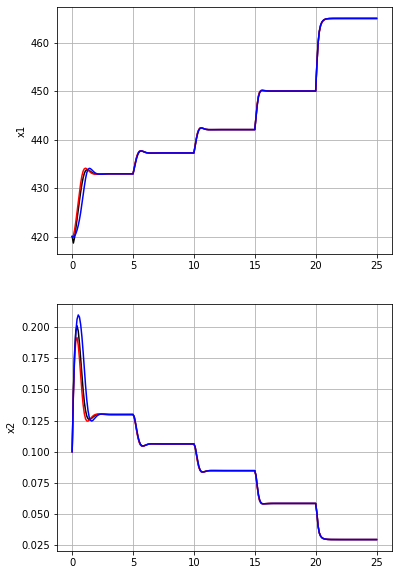

In [99]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_linear = np.array(x_linear_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_linear = x_plot_linear[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_appr, 'k')
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_linear, 'b')
    plt.ylabel('x' + str(i + 1))

#### Test: measurement noise

In [100]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk = x_init

ur_list = [110, 105, 98.9, 88.3, 68.6]
x1r_list = [432.94, 437.25, 442.07, 450.03, 465.00]
x2r_list = [0.1298, 0.1062, 0.0848, 0.0585, 0.0295]

x1_start = 420
x2_start = 0.1
u0 = np.array([[105]])


N = 50
N_len = len(step_input_list)


# for i in range(N * N_len):
#     if i % N == 0 and i != 0:
#         input_counter += 1
#     uk = step_input_list[input_counter]
#     u0 = uk
#     x_next = x_next_fn_lin(xk,xk,u0,uk)
# #     x_next = x_next_fn_lin(x0,xk,u0,uk)
# #     print(x_next)
#     x_list1.append(x_next.full().flatten().tolist())
#     x0 = xk
#     xk = x_next



### Appr
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2




x0 = np.array([[x1_start],[x2_start]])



x_appr_list = []

xk = x0
uk = u0


x_appr_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]



input_counter = 0



for i in range(N * N_len):
    x_lin = xk
    u_lin = uk

    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])   
    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    xk = x_next + ca.DM(np.array([[0.01,0.0001]]) @ np.random.rand(2,1))


### Real
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

x0 = np.array([[x1_start],[x2_start]])

xk = x0
uk = u0
x_real_list = []
x_real_list.append(xk.flatten().tolist())

input_counter = 0

for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])  
    
    
    p = np.vstack([xk,xr,ur])
    nl['p'] = p
    
    x_guess = [x1r_list[input_counter],x2r_list[input_counter]] * (N_pred+1) + [ur_list[input_counter]] * N_pred
    nl['x0'] = x_guess

    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next + ca.DM(np.array([[0.01,0.0001]]) @ np.random.rand(2,1))
### Linear
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2

x0 = np.array([[x1_start],[x2_start]])

xk = x0
uk = u0


x_linear_list = []
x_linear_list.append( xk.flatten().tolist())

input_counter = 0

for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])   
    x_lin = xr
    u_lin = ur    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p

    x_guess = [x1r_list[input_counter],x2r_list[input_counter]] * (N_pred + 1) + [ur_list[input_counter]] * N_pred
    nl['x0'] = x_guess
    
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]

    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_linear_list.append(x_next.full().flatten().tolist())
    
    xk = x_next + ca.DM(np.array([[0.01,0.0001]]) @ np.random.rand(2,1))

input [[ 32.88670101]
 [ 42.31380642]
 [ 52.5432103 ]
 [ 62.6974961 ]
 [ 72.23252905]
 [ 80.86113488]
 [ 88.48199766]
 [ 95.1157168 ]
 [100.84860996]
 [105.7839677 ]]
input [[ 33.73825982]
 [ 59.88631705]
 [ 79.93677021]
 [ 94.68066128]
 [104.94000188]
 [111.49397841]
 [115.03991943]
 [116.18022284]
 [115.42866447]
 [113.23145181]]
input [[ 58.85208291]
 [ 85.76544142]
 [103.57402747]
 [114.64961256]
 [120.82203394]
 [123.46127719]
 [123.56326073]
 [121.83340602]
 [118.76611718]
 [114.72116026]]
input [[ 85.13650572]
 [105.63990323]
 [117.73063163]
 [124.04894134]
 [126.49585906]
 [126.39659211]
 [124.64247065]
 [121.81140683]
 [118.27019456]
 [114.2640362 ]]
input [[109.87518323]
 [121.99550977]
 [127.65430209]
 [129.25223809]
 [128.42090937]
 [126.22178413]
 [123.30906616]
 [120.06019809]
 [116.68052009]
 [113.28993552]]
input [[120.68449763]
 [127.12070684]
 [129.04679862]
 [128.26446776]
 [126.02207798]
 [123.13234274]
 [120.08498635]
 [117.14663244]
 [114.44584796]
 [112.04470505]

input [[113.76408927]
 [110.44472601]
 [107.67473509]
 [105.77178073]
 [104.70505297]
 [104.27935687]
 [104.26017377]
 [104.44281858]
 [104.67941389]
 [104.87975926]]
input [[115.82515195]
 [111.77007844]
 [108.34209127]
 [105.9743239 ]
 [104.64481021]
 [104.11467026]
 [104.09101983]
 [104.31737449]
 [104.60902204]
 [104.85430373]]
input [[117.83450536]
 [112.98416079]
 [108.89657829]
 [106.09880046]
 [104.55490188]
 [103.96449825]
 [103.96560526]
 [104.24580061]
 [104.58457095]
 [104.85387653]]
input [[114.46373629]
 [110.34594722]
 [107.26860907]
 [105.37860208]
 [104.47769926]
 [104.2456038 ]
 [104.37319974]
 [104.62391132]
 [104.84846256]
 [104.97623459]]
input [[112.70618201]
 [109.11055959]
 [106.55850253]
 [105.06938343]
 [104.41500439]
 [104.29832884]
 [104.45342199]
 [104.68643227]
 [104.88064347]
 [104.98508466]]
input [[112.09656297]
 [108.82663171]
 [106.47396227]
 [105.07635658]
 [104.44176202]
 [104.30882724]
 [104.43869712]
 [104.65421579]
 [104.84616298]
 [104.96355771]

input [[106.14023963]
 [103.57329066]
 [101.31380844]
 [ 99.76705404]
 [ 98.91404407]
 [ 98.56741012]
 [ 98.51962901]
 [ 98.60855236]
 [ 98.73182041]
 [ 98.836321  ]]
input [[104.8425517 ]
 [102.38971136]
 [100.52856819]
 [ 99.38918696]
 [ 98.83581856]
 [ 98.6606115 ]
 [ 98.67984107]
 [ 98.76616225]
 [ 98.84730272]
 [ 98.89263675]]
input [[105.11059131]
 [102.56330279]
 [100.61617788]
 [ 99.4176256 ]
 [ 98.83136539]
 [ 98.64224729]
 [ 98.6588821 ]
 [ 98.74835445]
 [ 98.8351413 ]
 [ 98.8868758 ]]
input [[107.22011414]
 [104.04788608]
 [101.44202458]
 [ 99.75414007]
 [ 98.88115528]
 [ 98.56512373]
 [ 98.55382621]
 [ 98.66319991]
 [ 98.78429923]
 [ 98.86699143]]
input [[109.39150738]
 [105.4076298 ]
 [102.11652707]
 [ 99.99288137]
 [ 98.90642268]
 [ 98.52282987]
 [ 98.51665517]
 [ 98.65256244]
 [ 98.79335971]
 [ 98.87859584]]
input [[109.27274326]
 [105.10479355]
 [101.8779646 ]
 [ 99.90015649]
 [ 98.94598901]
 [ 98.64487878]
 [ 98.66940041]
 [ 98.79564347]
 [ 98.89938668]
 [ 98.93192965]

input [[72.59786575]
 [79.51162412]
 [71.15679028]
 [74.68034312]
 [70.33161894]
 [71.94325075]
 [69.78005575]
 [70.15617598]
 [69.27310456]
 [68.57213725]]
input [[79.42945304]
 [72.58067544]
 [76.36465362]
 [72.14230927]
 [74.19259829]
 [71.28882072]
 [72.41090496]
 [69.95959309]
 [70.65205713]
 [67.95634126]]
input [[74.77120242]
 [76.79378318]
 [72.97995963]
 [73.63415139]
 [71.70981337]
 [71.6499356 ]
 [70.70929516]
 [70.08757986]
 [69.74870016]
 [68.36457782]]
input [[76.81501648]
 [75.26235015]
 [74.74228725]
 [73.50585695]
 [73.18507421]
 [71.95919182]
 [71.82320043]
 [70.29389942]
 [70.38598631]
 [68.14639949]]
input [[74.14714383]
 [78.26696188]
 [72.69939834]
 [74.70878979]
 [71.66330525]
 [72.35838617]
 [70.78801397]
 [70.46941671]
 [69.85000318]
 [68.44634369]]
input [[75.43129924]
 [77.95615282]
 [74.03657634]
 [74.87995927]
 [72.79391112]
 [72.70699371]
 [71.59525412]
 [70.77101001]
 [70.26877587]
 [68.50322174]]
input [[75.76417058]
 [74.61070776]
 [73.98758749]
 [73.04

input [[117.72462138]
 [114.85019375]
 [112.50301469]
 [110.81911284]
 [109.77321133]
 [109.25471145]
 [109.12227836]
 [109.23763894]
 [109.4821717 ]
 [109.76107459]]
input [[117.4433838 ]
 [114.54192105]
 [112.22809514]
 [110.60555427]
 [109.62654376]
 [109.1669433 ]
 [109.07896556]
 [109.22286763]
 [109.48170144]
 [109.76409669]]
input [[121.28659533]
 [117.56037018]
 [114.31778566]
 [111.85656012]
 [110.22414259]
 [109.32219935]
 [108.98602448]
 [109.03701194]
 [109.31134203]
 [109.67049883]]
input [[119.95818261]
 [116.16403044]
 [113.10266126]
 [110.93127972]
 [109.60177115]
 [108.95989093]
 [108.81571519]
 [108.98664593]
 [109.3179692 ]
 [109.68739129]]
input [[120.13932996]
 [116.23410467]
 [113.10036422]
 [110.88944182]
 [109.54489546]
 [108.90408379]
 [108.76993179]
 [108.9544458 ]
 [109.29925144]
 [109.67981772]]
input [[117.32448314]
 [113.95071376]
 [111.46845457]
 [109.87179195]
 [109.02166576]
 [108.72688015]
 [108.79636106]
 [109.06699452]
 [109.41327623]
 [109.74519048]

input [[110.22600885]
 [105.77382398]
 [102.22478147]
 [ 99.91292946]
 [ 98.68456386]
 [ 98.21556885]
 [ 98.18731039]
 [ 98.35964475]
 [ 98.58195164]
 [ 98.77434497]]
input [[107.2632378 ]
 [103.38539723]
 [100.65495736]
 [ 99.06906045]
 [ 98.35222926]
 [ 98.17916355]
 [ 98.28147374]
 [ 98.47915026]
 [ 98.672129  ]
 [ 98.81655601]]
input [[103.84080438]
 [101.07518559]
 [ 99.37349705]
 [ 98.53366139]
 [ 98.26281355]
 [ 98.29969937]
 [ 98.45915774]
 [ 98.63269073]
 [ 98.77015133]
 [ 98.85777527]]
input [[102.03737606]
 [100.17845589]
 [ 99.07826383]
 [ 98.56545773]
 [ 98.42608529]
 [ 98.47937571]
 [ 98.60202054]
 [ 98.72466753]
 [ 98.81741279]
 [ 98.87410812]]
input [[104.82738932]
 [102.67591896]
 [100.85086106]
 [ 99.60323704]
 [ 98.90197689]
 [ 98.60361881]
 [ 98.55147656]
 [ 98.62070324]
 [ 98.72909322]
 [ 98.83018614]]
input [[106.50228975]
 [103.77895288]
 [101.44532991]
 [ 99.83827347]
 [ 98.92765281]
 [ 98.53464579]
 [ 98.46028835]
 [ 98.54461081]
 [ 98.68149958]
 [ 98.81047695]

input [[98.18668484]
 [94.50493517]
 [91.60193199]
 [89.80288791]
 [88.85420934]
 [88.42604376]
 [88.27022815]
 [88.23737718]
 [88.25085533]
 [88.27664935]]
input [[96.03169698]
 [92.70116011]
 [90.44862661]
 [89.17929974]
 [88.56456869]
 [88.31487709]
 [88.24068676]
 [88.237979  ]
 [88.25790833]
 [88.28110473]]
input [[93.71351307]
 [91.21021907]
 [89.6388395 ]
 [88.80142886]
 [88.41869508]
 [88.27590361]
 [88.2420259 ]
 [88.24909144]
 [88.2671558 ]
 [88.28543808]]
input [[95.83839862]
 [92.96411071]
 [90.752368  ]
 [89.40021525]
 [88.69518796]
 [88.38108947]
 [88.2693355 ]
 [88.24792318]
 [88.26011012]
 [88.28107017]]
input [[51.03447403]
 [59.16968407]
 [63.66479214]
 [66.11581491]
 [67.42948751]
 [68.11658977]
 [68.46160457]
 [68.62015039]
 [68.67431411]
 [68.66338532]]
input [[61.57277775]
 [65.37451461]
 [67.30375552]
 [68.24067143]
 [68.66387988]
 [68.82882068]
 [68.86802451]
 [68.84674026]
 [68.79309322]
 [68.71360393]]
input [[68.04793001]
 [69.09966647]
 [69.43381415]
 [69.45

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/4115106661.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/4115106661.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


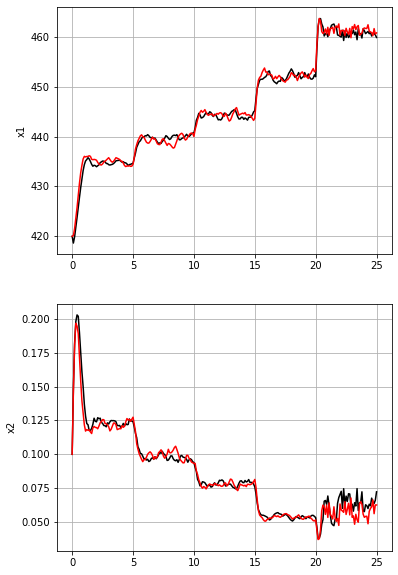

In [101]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_linear = np.array(x_linear_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_linear = x_plot_linear[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_appr, 'k')
    plt.plot(tgrid, x_opt_real, 'r')
#     plt.plot(tgrid, x_opt_linear, 'b')
    plt.ylabel('x' + str(i + 1))

### Mass spring system

In [102]:
def mass_string_ode(x, u):
    m = 2  # [kg]
    k1 = 3  # [N/m]
    k2 = 2  # [N/m]

    A = ca.DM([[0, 1], [-k2 / m, -k1 / m]])
    B = ca.DM([[0], [1 / m]])

    dot_x = A @ x + B @ u

    return dot_x

In [103]:
x_SX = ca.SX.sym("x_SX", 2)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [mass_string_ode(x_SX, u_SX)])
delta_t = 0.1
# N = 5

In [104]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])
A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 2)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 2)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0)
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])


In [105]:
x_next

SX(@1=0.0166667, @2=2, @3=0.05, @4=-1.5, @5=(0.5*u0_SX), @6=(((@4*x0_SX_1)-x0_SX_0)+@5), @7=(x0_SX_1+(@3*@6)), @8=(((@4*@7)-(x0_SX_0+(@3*x0_SX_1)))+@5), @9=(x0_SX_1+(@3*@8)), @10=0.1, @11=(((@4*@9)-(x0_SX_0+(@3*@7)))+@5), @12=(x0_SX_1+(@10*@11)), @13=(xk_SX_0-x0_SX_0), @14=(xk_SX_1-x0_SX_1), @15=(uk_SX-u0_SX), [(((x0_SX_0+(@1*(((x0_SX_1+(@2*@7))+(@2*@9))+@12)))+((0.995245*@13)+(0.0927068*@14)))+(0.0023776*@15)), (((x0_SX_1+(@1*(((@6+(@2*@8))+(@2*@11))+(((@4*@12)-(x0_SX_0+(@10*@9)))+@5))))+((-0.0927068*@13)+(0.856185*@14)))+(0.0463534*@15))])

In [106]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_init = np.array([[0],[0]])

uk = np.array([[0]])
xk = x_init

step_input_list = [1,2,3,4,5]
N_len = len(step_input_list)

N = 50
input_counter = 0
for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1
    uk = step_input_list[input_counter]
    u0 = uk
    x_next = x_next_fn_lin(xk,xk,u0,uk)
#     x_next = x_next_fn_lin(x0,xk,u0,uk)
#     print(x_next)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

In [107]:
x_list1

[[432.94, 0.1298],
 [0.0023776041666666668, 0.04635338541666666],
 [0.009041175009358724, 0.08582002180535209],
 [0.01933188359969821, 0.11899299135787575],
 [0.032649016612959963, 0.14644115983689418],
 [0.048447454949320026, 0.16870727156054036],
 [0.06623498773696285, 0.18630655210642363],
 [0.08556950956886317, 0.19972576097836195],
 [0.10605614324308284, 0.20942264034932048],
 [0.12734432507977483, 0.21582570982504168],
 [0.14912488507131108, 0.21933436093466707],
 [0.17112714967682507, 0.22031920872200897],
 [0.19311609098846155, 0.21912266136315744],
 [0.21488954226134346, 0.21605967215591487],
 [0.23627549639878634, 0.2114186415008209],
 [0.25712950090352626, 0.2054624396121596],
 [0.27733216002873273, 0.19842952365306984],
 [0.29678675237280205, 0.19053512577697607],
 [0.3154169699424691, 0.18197249117550104],
 [0.33316478274256855, 0.17291414768022476],
 [0.3499884312207963, 0.16351319074319096],
 [0.36586054738520773, 0.1539045697314373],
 [0.3807664041044055, 0.144206363417

/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1589118732.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/1589118732.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


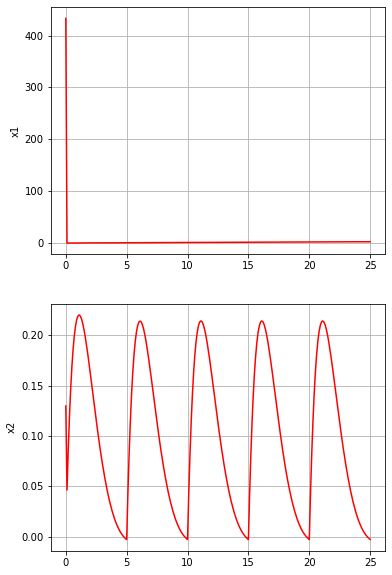

In [108]:
x_plot = np.array(x_list1)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [109]:
x_SX = ca.SX.sym("x_SX", 2)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [mass_string_ode(x_SX, u_SX)])
delta_t = 0.1

sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 2)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 2)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0) 
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

delta_fn = ca.Function("delta_fn", [x0,u0], [sys_int_fn(x0,u0) - A_fn(x0,u0) @  x0 - B_fn(x0,u0) @ u0] )

In [110]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]

N_pred = 10

xi_var = ca.SX.sym('x', 2, N_pred+1)
# xi_var = ca.SX.sym('x', 4, N_pred)
x0_para = ca.SX.sym('x0', 2, 1)
x_lin_para = ca.SX.sym('xlin', 2, 1)
xr_para = ca.SX.sym('xr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)
ur_para = ca.SX.sym('ur', 1, 1)
# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []

delta = delta_fn(x_lin_para,u_lin_para)
for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  (xi_var[:,i] - xr_para).T @ Q @  (xi_var[:,i] - xr_para) + (ui_var[:,i] - ur_para).T @ R @ (ui_var[:,i] - ur_para)
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:,i-1] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,i-1] + delta)]

obj += (xi_var[:, -1]- xr_para).T @ Qf @ (xi_var[:, -1]- xr_para)
g += [xi_var[:, -1] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        
# g += [terminal_state - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        

# g += [xi_var[:, -1] - terminal_state]
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para, x_lin_para, u_lin_para, xr_para,ur_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_appr = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



In [111]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[0]])
xk = x_init

# ur_list = [110, 105, 98.9, 88.3, 68.6]
ur_list = [0] * 5
x1r_list = [0.5, 1, 1.5, 2, 2.5]
x2r_list = [0] * 5
# x2r_list = [0.1298, 0.1062, 0.0848, 0.0585, 0.0295]

x1_start = 0
x2_start = 0
u0 = np.array([[0]])


N = 60
N_len = len(step_input_list)


# for i in range(N * N_len):
#     if i % N == 0 and i != 0:
#         input_counter += 1
#     uk = step_input_list[input_counter]
#     u0 = uk
#     x_next = x_next_fn_lin(xk,xk,u0,uk)
# #     x_next = x_next_fn_lin(x0,xk,u0,uk)
# #     print(x_next)
#     x_list1.append(x_next.full().flatten().tolist())
#     x0 = xk
#     xk = x_next



### Appr
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

x0 = np.array([[x1_start],[x2_start]])



x_appr_list = []

xk = x0
uk = u0


x_appr_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]



input_counter = 0



for i in range(N * N_len):
    x_lin = xk
    u_lin = uk

    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])   
    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    xk = x_next

input [[ 5.96748461e-01]
 [ 4.82907788e-01]
 [ 3.82056011e-01]
 [ 2.93026811e-01]
 [ 2.15093934e-01]
 [ 1.47982471e-01]
 [ 9.18886136e-02]
 [ 4.75085151e-02]
 [ 1.60769971e-02]
 [-5.83101052e-04]]
input [[ 5.56589419e-01]
 [ 4.51312985e-01]
 [ 3.57830038e-01]
 [ 2.75080974e-01]
 [ 2.02424923e-01]
 [ 1.39651165e-01]
 [ 8.69987966e-02]
 [ 4.51852534e-02]
 [ 1.54443885e-02]
 [-4.25099932e-04]]
input [[5.23348523e-01]
 [4.25569228e-01]
 [3.38500561e-01]
 [2.61176959e-01]
 [1.93031281e-01]
 [1.33906345e-01]
 [8.40744806e-02]
 [4.42656820e-02]
 [1.57050468e-02]
 [1.60259931e-04]]
input [[0.49602281]
 [0.40479932]
 [0.32330645]
 [0.25066143]
 [0.18636068]
 [0.13029142]
 [0.0827511 ]
 [0.04447516]
 [0.01667387]
 [0.0010788 ]]
input [[0.47374134]
 [0.38824396]
 [0.31159107]
 [0.24297273]
 [0.18194003]
 [0.12841678]
 [0.08271877]
 [0.0455812 ]
 [0.01819481]
 [0.00225144]]
input [[0.45574895]
 [0.37524702]
 [0.30278903]
 [0.23762906]
 [0.17936511]
 [0.12795089]
 [0.08371496]
 [0.0473877 ]
 [0.020

input [[0.90311504]
 [0.80363108]
 [0.70632246]
 [0.61055506]
 [0.51598978]
 [0.42260684]
 [0.33073827]
 [0.24110977]
 [0.15489269]
 [0.0737675 ]]
input [[0.90347166]
 [0.80397432]
 [0.7066486 ]
 [0.61086031]
 [0.51627006]
 [0.42285755]
 [0.33095411]
 [0.24128444]
 [0.1550187 ]
 [0.07383588]]
input [[0.90379583]
 [0.80428568]
 [0.70694391]
 [0.61113626]
 [0.51652308]
 [0.42308361]
 [0.3311485 ]
 [0.24144162]
 [0.15513199]
 [0.07389731]]
input [[0.90409021]
 [0.80456784]
 [0.70721105]
 [0.6113855 ]
 [0.51675131]
 [0.42328727]
 [0.33132345]
 [0.24158293]
 [0.15523377]
 [0.07395245]]
input [[0.90435726]
 [0.8048233 ]
 [0.7074525 ]
 [0.61161044]
 [0.516957  ]
 [0.4234706 ]
 [0.33148077]
 [0.24170988]
 [0.15532513]
 [0.07400191]]
input [[0.90459929]
 [0.80505439]
 [0.70767055]
 [0.61181327]
 [0.51714223]
 [0.42363551]
 [0.33162214]
 [0.24182386]
 [0.15540708]
 [0.07404625]]
input [[0.90481843]
 [0.80526324]
 [0.70786729]
 [0.61199603]
 [0.51730892]
 [0.42378373]
 [0.33174907]
 [0.2419261 ]


input [[1.78063403]
 [1.58065261]
 [1.38574037]
 [1.19460654]
 [1.00657893]
 [0.82165242]
 [0.64055465]
 [0.46483069]
 [0.29694874]
 [0.14042922]]
input [[1.78276328]
 [1.58299551]
 [1.38820755]
 [1.19711234]
 [1.00903814]
 [0.82397711]
 [0.64265088]
 [0.4665951 ]
 [0.29826503]
 [0.14116433]]
input [[1.78483456]
 [1.58524203]
 [1.39054985]
 [1.19947408]
 [1.01134319]
 [0.82614664]
 [0.6446004 ]
 [0.4682314 ]
 [0.2994829 ]
 [0.14184316]]
input [[1.78683437]
 [1.58738437]
 [1.3927641 ]
 [1.20169225]
 [1.01349732]
 [0.82816612]
 [0.6464093 ]
 [0.46974569]
 [0.30060752]
 [0.14246887]]
input [[1.78875285]
 [1.58941759]
 [1.39484934]
 [1.20376901]
 [1.01550495]
 [0.83004143]
 [0.64808411]
 [0.47114433]
 [0.30164414]
 [0.14304463]]
input [[1.79058313]
 [1.59133908]
 [1.39680637]
 [1.20570779]
 [1.01737141]
 [0.83177903]
 [0.6496317 ]
 [0.47243379]
 [0.30259803]
 [0.1435736 ]]
input [[1.79232082]
 [1.59314812]
 [1.3986374 ]
 [1.20751302]
 [1.01910265]
 [0.83338576]
 [0.65105906]
 [0.47362055]


 [0.1856567 ]]
input [[2.26496094]
 [2.01589408]
 [1.77221083]
 [1.53232321]
 [1.29537705]
 [1.06131254]
 [0.8309456 ]
 [0.60607211]
 [0.38959778]
 [0.18569641]]
input [[2.26515919]
 [2.01608267]
 [1.7723882 ]
 [1.53248774]
 [1.29552693]
 [1.06144567]
 [0.83105949]
 [0.60616377]
 [0.38966357]
 [0.18573195]]
input [[2.26533837]
 [2.01625282]
 [1.77254799]
 [1.53263575]
 [1.29566158]
 [1.06156514]
 [0.8311616 ]
 [0.60624587]
 [0.38972246]
 [0.18576375]]
input [[2.26550019]
 [2.01640622]
 [1.77269182]
 [1.5327688 ]
 [1.29578248]
 [1.06167229]
 [0.83125308]
 [0.60631936]
 [0.38977514]
 [0.18579216]]
input [[2.26564619]
 [2.0165444 ]
 [1.77282119]
 [1.5328883 ]
 [1.29589094]
 [1.06176831]
 [0.83133498]
 [0.6063851 ]
 [0.38982221]
 [0.18581754]]


/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/284947053.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
/var/folders/_9/6rdb7slj2m5_lr9gft0c_m780000gn/T/ipykernel_70124/284947053.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


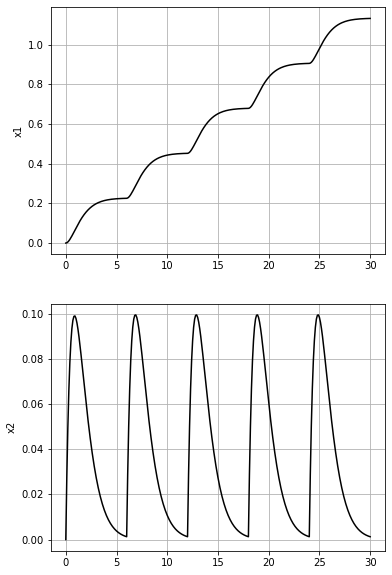

In [112]:
# x_plot_real = np.array(x_real_list)
# tgrid = [delta_t * k for k in range(N * N_len + 1)]

# x_plot_linear = np.array(x_linear_list)
# tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
#     x_opt_real = x_plot_real[:,i]
#     x_opt_linear = x_plot_linear[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_appr, 'k')
#     plt.plot(tgrid, x_opt_real, 'r')
#     plt.plot(tgrid, x_opt_linear, 'b')
    plt.ylabel('x' + str(i + 1))